# Stock market forecasting using Time Series analysis

### What is a Stock market?

The stock market is a market that enables the seamless exchange of buying and selling of company stocks. Every Stock Exchange has its own Stock Index value. The index is the average value that is calculated by combining several stocks. This helps in representing the entire stock market and predicting the market’s movement over time. The stock market can have a huge impact on people and the country’s economy as a whole. Therefore, predicting the stock trends in an efficient manner can minimize the risk of loss and maximize profit.

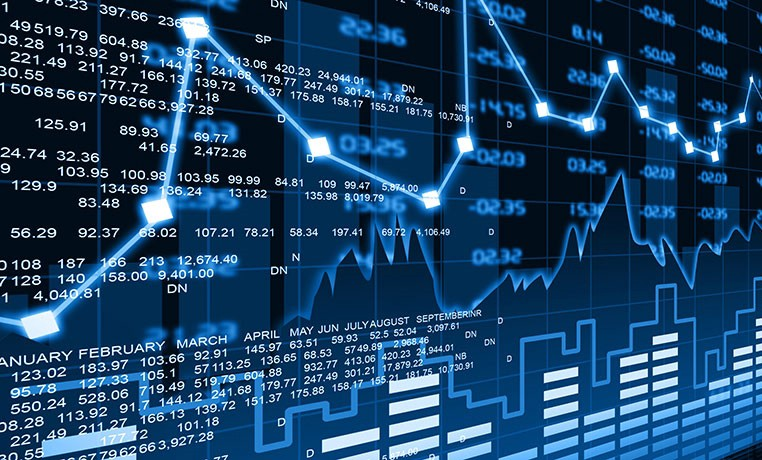

**Here in this notebook we will forecast the stock price of ARCH CAPITAL GROUP using ARIMA model**

### What is ARIMA?
Autoregressive Integrated Moving Average (ARIMA) Model converts non-stationary data to stationary data before working on it. It is one of the most popular models to predict linear time series data.


ARIMA model has been used extensively in the field of finance and economics as it is known to be robust, efficient and has a strong potential for short-term share market prediction.



### Load all the required libraries

In [24]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 6.5 MB/s eta 0:00:01
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [104]:
# dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
# stock_data = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/acgl.us.txt',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

symbol = 'NVDA'
start = '2010-01-01'
end = '2023-12-31'
stock_data = yf.download(symbol, start=start, end=end, interval='1d')[['Adj Close']]

[*********************100%***********************]  1 of 1 completed


In [105]:
stock_data

,Adj Close
Date,
2010-01-04,0.423952
2010-01-05,0.430143
2010-01-06,0.432894
2010-01-07,0.424410
2010-01-08,0.425328
...,...
2023-12-22,48.819527
2023-12-26,49.268425
2023-12-27,49.406395


Visualize the per day closing price of the stock.

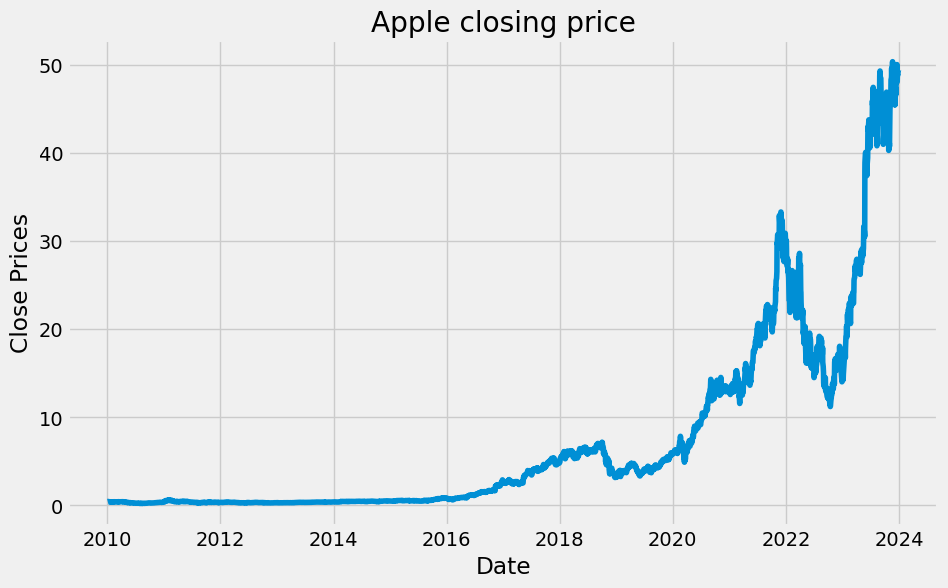

In [106]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Adj Close'])
plt.title('Apple closing price')
plt.show()

### We can also visualize the data in our series through a probability distribution too.

<Axes: ylabel='Density'>

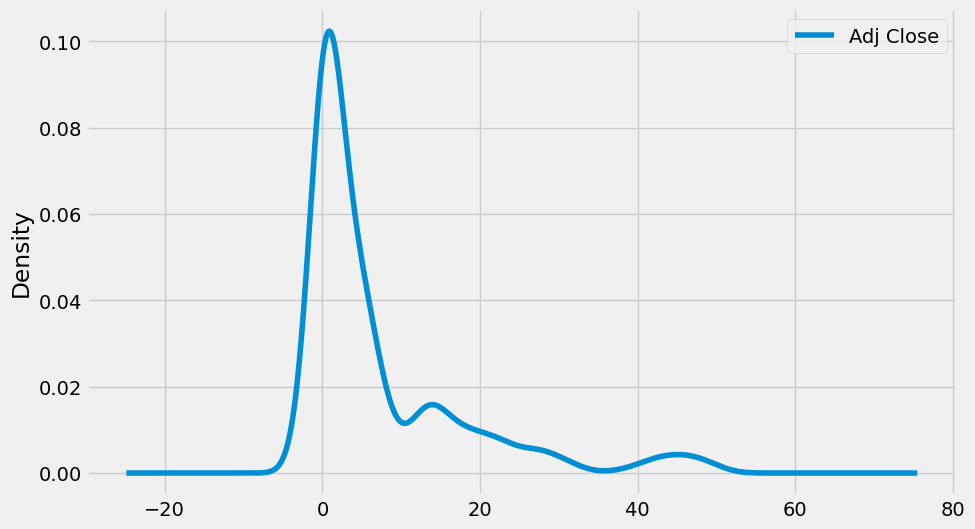

In [107]:
#Distribution of the dataset
stock_data.plot(kind='kde')

Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

1. **Level**: The average value in the series.

2. **Trend**: The increasing or decreasing value in the series.

3. **Seasonality**: The repeating short-term cycle in the series.

4. **Noise**: The random variation in the series.

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.


**ADF (Augmented Dickey-Fuller) Test**

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:


**Null Hypothesis**: The series has a unit root (value of a =1)


**Alternate Hypothesis**: The series has no unit root.


If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.


If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.


**So let's check for stationarity:

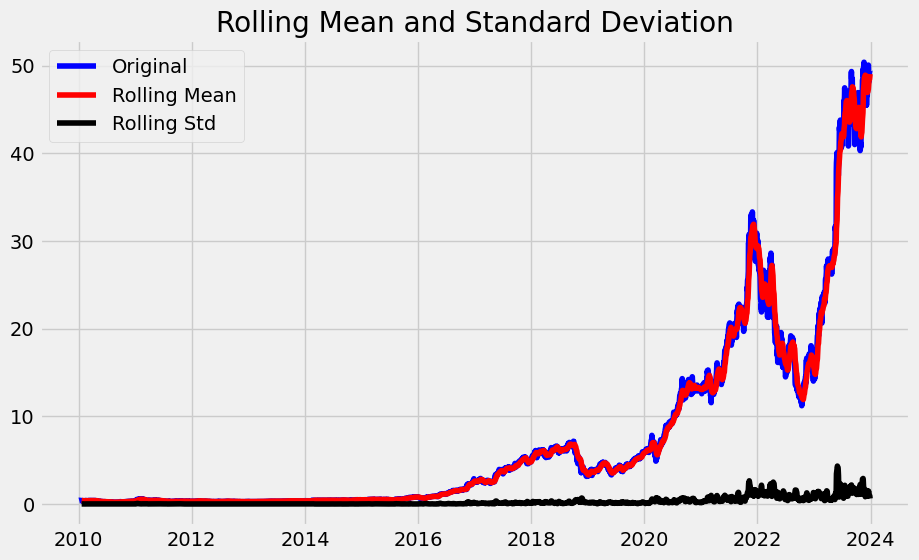

Results of dickey fuller test
Test Statistics                   2.142872
p-value                           0.998832
No. of lags used                 27.000000
Number of observations used    3494.000000
critical value (1%)              -3.432223
critical value (5%)              -2.862368
critical value (10%)             -2.567211
dtype: float64


In [108]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(stock_data)

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.


In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.


So let us separate Trend and Seasonality from the time series.

In [109]:
stock_data

,Adj Close
Date,
2010-01-04,0.423952
2010-01-05,0.430143
2010-01-06,0.432894
2010-01-07,0.424410
2010-01-08,0.425328
...,...
2023-12-22,48.819527
2023-12-26,49.268425
2023-12-27,49.406395


We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


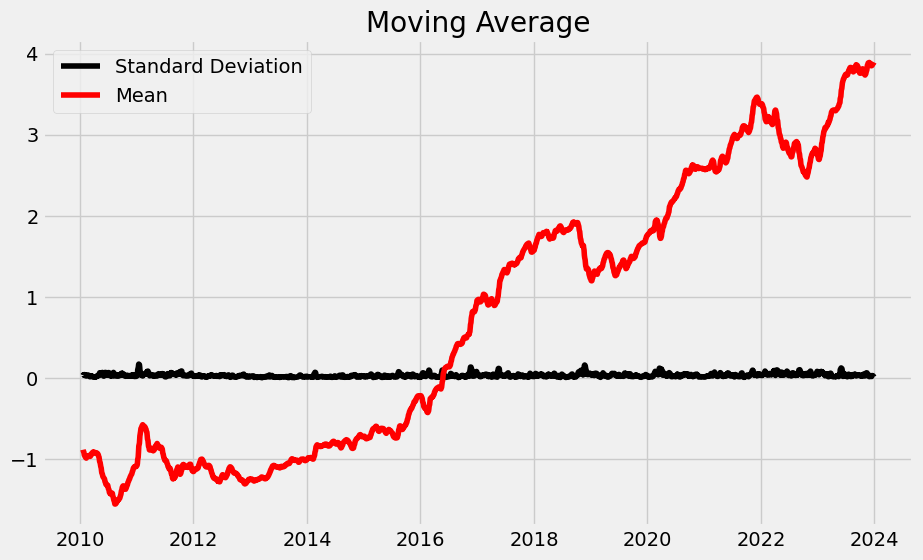

In [110]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(stock_data)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

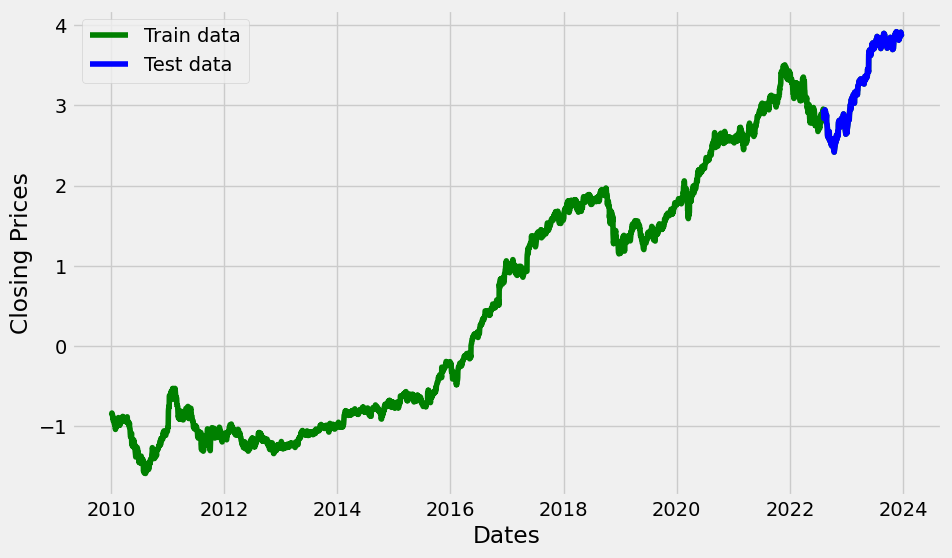

In [124]:

#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

#### Auto ARIMA: Automatically discover the optimal order for an ARIMA model.


The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, **forecast::auto.arima**.


The **auro_arima** function works by conducting differencing tests (i.e., **Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron**) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the **Canova-Hansen** to determine the optimal order of seasonal differencing, D.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13746.443, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13756.227, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13755.494, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13742.408, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13757.227, Time=0.35 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-13755.231, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-13755.232, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13756.702, Time=0.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-13753.229, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-13752.842, Time=0.13 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.286 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3166
Model:               SARIMAX(2, 1, 0)   Lo

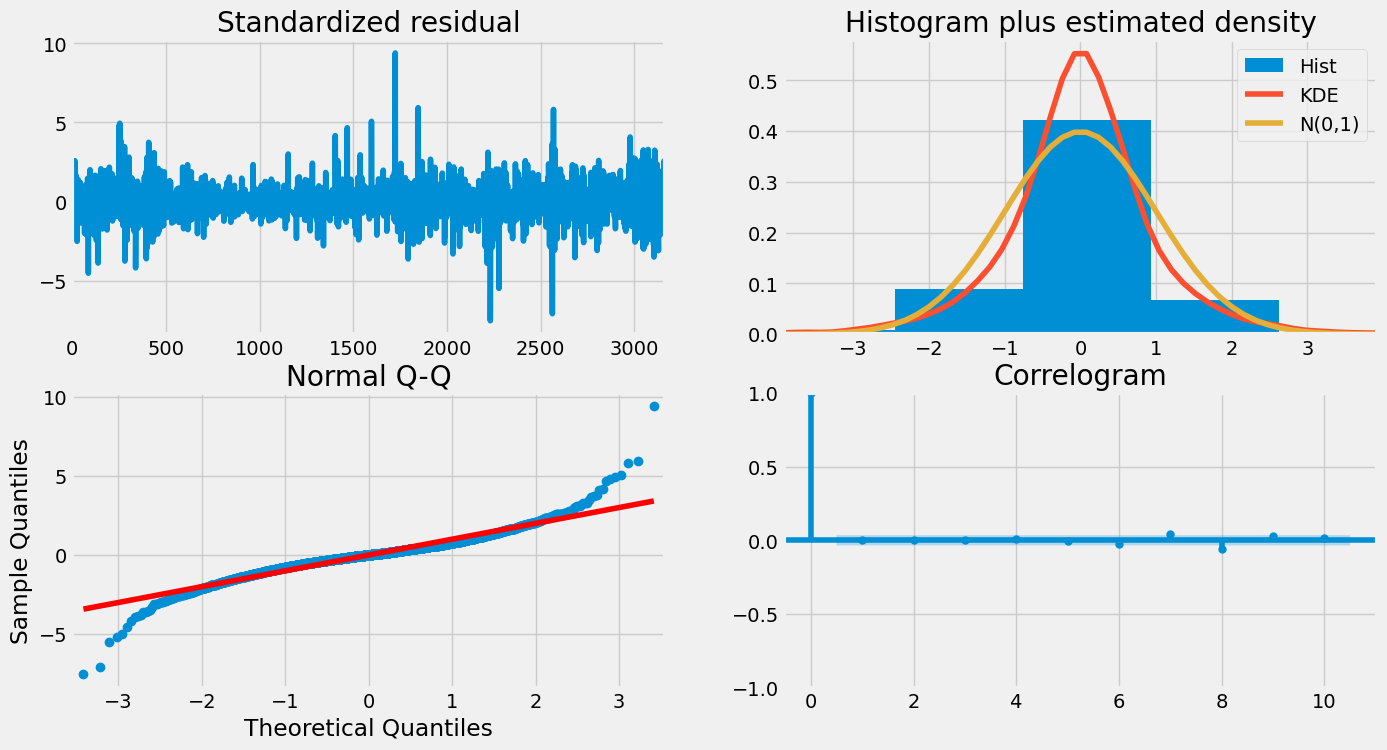

In [125]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

So how to interpret the plot diagnostics?


**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.


**Top Right**: The density plot suggest normal distribution with mean zero.


**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.


**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.


Overall, it seems to be a good fit. Let’s start forecasting the stock prices.


Next, create an ARIMA model with provided optimal parameters p, d and q.

**So the Auto ARIMA model provided the value of p,d, and q as 1, 1 and 2 respectively.**

In [126]:
print(train_data
)

            Adj Close
Date                 
2010-01-07  -0.857055
2010-01-08  -0.854896
2010-01-11  -0.869011
2010-01-12  -0.903497
2010-01-13  -0.890006
...               ...
2022-07-29   2.898175
2022-08-01   2.913365
2022-08-02   2.917964
2022-08-03   2.937580
2022-08-04   2.954480

[3166 rows x 1 columns]


In [127]:
#Modeling
# Build Model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(2,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 3166
Model:                 ARIMA(2, 1, 0)   Log Likelihood                6879.421
Date:                Fri, 20 Sep 2024   AIC                         -13752.842
Time:                        18:05:58   BIC                         -13734.663
Sample:                             0   HQIC                        -13746.321
                               - 3166                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0570      0.012     -4.764      0.000      -0.080      -0.034
ar.L2          0.0329      0.013      2.500      0.012       0.007       0.059
sigma2         0.0008   8.96e-06     84.596      0.0

### Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

Plot the results

In [128]:
# Forecasting 321 periods ahead with 95% confidence intervals
forecast_results = fitted.get_forecast(steps=500)
fc = forecast_results.predicted_mean
conf = forecast_results.conf_int(alpha=0.05)

print(forecast_results)
print(fc)
print(conf)

# Check the structure of conf
# print(conf)


3166    2.954161
3167    2.954735
3168    2.954691
3169    2.954713
3170    2.954710
          ...   
3661    2.954711
3662    2.954711
3663    2.954711
3664    2.954711
3665    2.954711
Name: predicted_mean, Length: 500, dtype: float64
      lower Adj Close  upper Adj Close
3166         2.900214         3.008108
3167         2.880585         3.028884
3168         2.863653         3.045730
3169         2.849567         3.059858
3170         2.837104         3.072316
...               ...              ...
3661         1.781605         4.127816
3662         1.780423         4.128998
3663         1.779243         4.130179
3664         1.778063         4.131359
3665         1.776885         4.132537

[500 rows x 2 columns]


In [129]:
# Create a forecast series with future dates

future_dates = pd.date_range(start=train_data.index[-1], periods=500, freq='B')
fc_series = pd.Series(fc.values, index=future_dates)  # Use .values to avoid index misalignment

# fc_series = pd.Series(fc, index=pd.date_range(start=train_data.index[-1],))
print(fc_series)
# Extract the lower and upper bounds from confidence intervals
lower_series = conf.iloc[:, 0]  # First column for lower bound
upper_series = conf.iloc[:, 1]  # Second column for upper bound

2022-08-04    2.954161
2022-08-05    2.954735
2022-08-08    2.954691
2022-08-09    2.954713
2022-08-10    2.954710
                ...   
2024-06-27    2.954711
2024-06-28    2.954711
2024-07-01    2.954711
2024-07-02    2.954711
2024-07-03    2.954711
Freq: B, Length: 500, dtype: float64


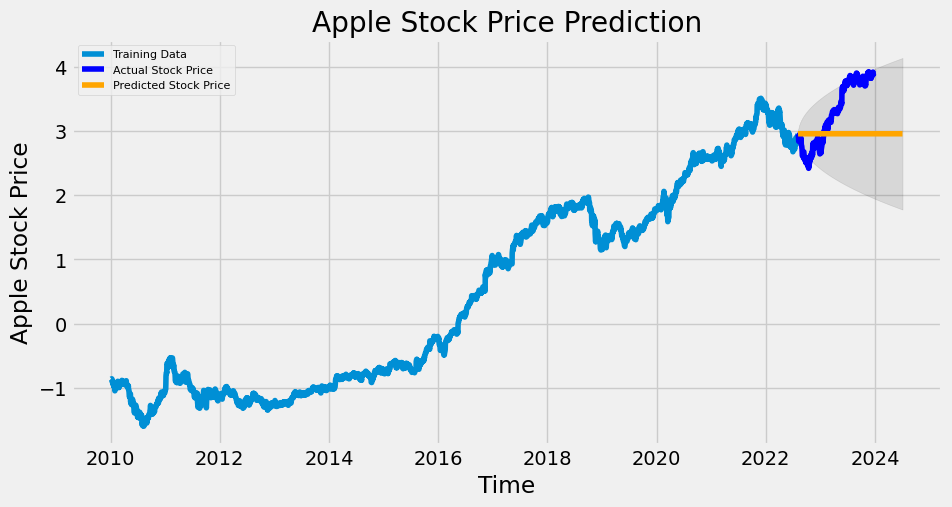

In [130]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(fc_series.index, lower_series, upper_series, color='k', alpha=0.10)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

As you can see our model did quite handsomely. Let us also check the commonly used accuracy metrics to judge forecast results:

In [131]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import math

# Make sure fc_series is used for actual comparison
# Trim the test_data to match the length of the forecast if necessary
test_data_trimmed = test_data[:len(fc_series)]

# Calculate performance metrics
mse = mean_squared_error(test_data_trimmed, fc_series)
print('MSE: ' + str(mse))

mae = mean_absolute_error(test_data_trimmed, fc_series)
print('MAE: ' + str(mae))

rmse = math.sqrt(mse)
print('RMSE: ' + str(rmse))

mape = np.mean(np.abs(fc_series - test_data_trimmed) / np.abs(test_data_trimmed)) * 100  # Multiply by 100 for percentage
print('MAPE: ' + str(mape) + '%')

ValueError: Found input variables with inconsistent numbers of samples: [353, 500]

### Around 2.5% MAPE implies the model is about 97.5% accurate in predicting the next 15 observations.
